# Deep Learning Course Final Project
## Sentiment Analysis of Social Media’s Messages
### Authors:
- **Nikita Breslavsky** 
- **Barak Finkel**
- **Gilad Fisher**

In [23]:
import re

import keras.layers
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Visualization
import plotly.express as px
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf # Deep Learning
import tensorflow_hub as hub # Pre-trained models

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preprocessing

In [24]:
df = pd.read_csv('Twitter_Data.csv') # twitter posts
df2 = pd.read_csv('Reddit_Data.csv') # reddit posts
df2 = df2.rename(columns={'clean_comment': 'clean_text'}) # rename the column to match the twitter data
df = pd.concat([df, df2]) # merge the two dataframes
df.reset_index(drop=True, inplace=True) # reset the index
df.head() # Show the first 5 rows of the data

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [25]:
df.info() # Show the data types and the number of non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  200125 non-null  object 
 1   category    200222 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


In [26]:
# count null values
df.isnull().sum()

clean_text    104
category        7
dtype: int64

In [27]:
# drop null values because they are not significant
df.dropna(inplace=True)

In [28]:
# name categories for data visualization
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

In [29]:
# draw a pie chart of the different sentiments of the posts
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of posts')
fig.show()

In [30]:
# import wordcloud
# def wordcount_gen(df, category):
#     '''
#     Generating Word Cloud
#     inputs:
#        - df: tweets dataset
#        - category: Positive/Negative/Neutral
#     '''
#     # Combine all tweets
#     combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
# 
#     # Initialize wordcloud object
#     wc = wordcloud.WordCloud(background_color='white',
#                    max_words=50,
#                    stopwords = wordcloud.STOPWORDS)
# 
#     # Generate and plot wordcloud
#     plt.figure(figsize=(10,10))
#     plt.imshow(wc.generate(combined_tweets))
#     plt.title('{} Sentiment Words'.format(category), fontsize=20)
#     plt.axis('off')
#     plt.show()
# 
# # Positive tweet words
# wordcount_gen(df, 'Positive')
# 
# # Negative tweet words
# wordcount_gen(df, 'Negative')
# 
# # Neutral tweet words
# wordcount_gen(df, 'Neutral')

In [31]:
pattern  = re.compile(r"[^a-zA-Z0-9]") 
def post_to_words(post):
    ''' Convert tweet text into a sequence of words '''
    # convert to lower case
    text = post.lower()
    # remove non letters
    text = re.sub(pattern, " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", post_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [32]:
# Apply data processing to each tweet
X = list(map(post_to_words, df['clean_text']))

In [33]:
# Convert the categories to numbers
df['category'] = df['category'].apply(lambda x: 0 if x == 'Negative' else (1 if x == 'Neutral' else 2)) # Convert the labels to numerical values

In [34]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
    df = dataframe.copy() # avoid modifying the original dataframe
    labels = df.pop("category") # Remove the label column from the dataframe
    df = df["clean_text"] # Keep only the description column
    ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
    if shuffle: # Shuffle the dataset if needed
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)  # Batch the dataset
    ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
    return ds

In [35]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data 
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



## Model

In [36]:
# Embedding model
embedding = "https://www.kaggle.com/models/google/nnlm/frameworks/TensorFlow2/variations/en-dim50/versions/1" # Load the embedding model
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True) # Create a keras layer with the embedding model

In [60]:
# Create the model
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [61]:
epochs=5
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.95

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate),
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [62]:
# Check the model
model.evaluate(train_data) # Evaluate the model on the test data

157/157 [==============================] - 4s 21ms/step - loss: 1.0686 - accuracy: 0.4684


[1.0685526132583618, 0.468412309885025]

In [63]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = epochs,
    batch_size= 64,
    verbose = 1
)

Epoch 1/5
157/157 [==============================] - 25s 154ms/step - loss: 0.3406 - accuracy: 0.8771 - val_loss: 0.2152 - val_accuracy: 0.9290
Epoch 2/5
157/157 [==============================] - 24s 155ms/step - loss: 0.1626 - accuracy: 0.9471 - val_loss: 0.2134 - val_accuracy: 0.9286
Epoch 3/5
157/157 [==============================] - 25s 156ms/step - loss: 0.1218 - accuracy: 0.9592 - val_loss: 0.2340 - val_accuracy: 0.9298
Epoch 4/5
157/157 [==============================] - 24s 154ms/step - loss: 0.0981 - accuracy: 0.9660 - val_loss: 0.2494 - val_accuracy: 0.9311
Epoch 5/5
157/157 [==============================] - 24s 154ms/step - loss: 0.0817 - accuracy: 0.9709 - val_loss: 0.2599 - val_accuracy: 0.9318


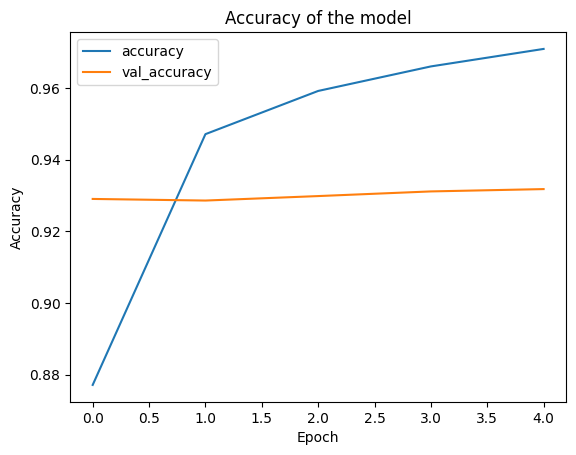

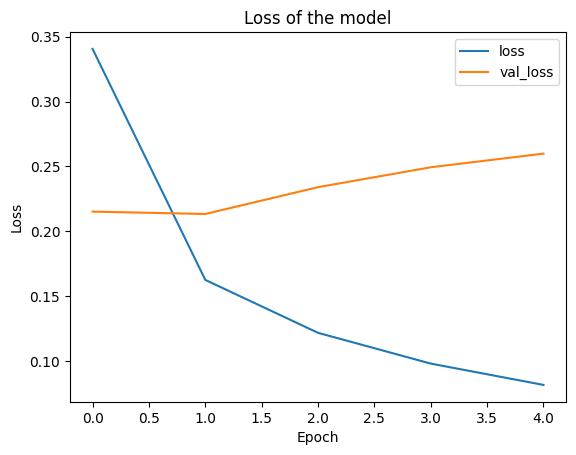

In [64]:
# Draw plot of the model's accuracy
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Draw plot of the model's loss
plt.plot(history.history['loss'], label='loss') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_loss'], label = 'val_loss') # Plot the accuracy of the model on the validation data
plt.title('Loss of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
model.evaluate(test_data) # Evaluate the model on the test data

20/20 [==============================] - 0s 21ms/step - loss: 0.2696 - accuracy: 0.9308


[0.2695716619491577, 0.9308415055274963]

In [59]:
def predict_sentiment(model, text, expected):
    text = text.lower()  # Convert the text to lowercase

    # Convert the text to a pandas DataFrame
    df = pd.DataFrame([text], columns=['Tweet'])

    # Preprocess the text
    df['Tweet'] = df['Tweet'].apply(post_to_words)
    df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(x))

    # Predict sentiment
    prediction = model.predict([df['Tweet'].iloc[0]])
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    # Map the numerical label back to the original label
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_map[predicted_label]

    # Check if prediction succeeded
    success = "Success" if predicted_sentiment.lower() == expected.lower() else "Failed"

    # Print the results
    print(f"Original text: '{text}'")
    print(f"Processed text: '{df['Tweet'][0]}'")
    print(f"Expected sentiment: {expected}")
    print(f"Predicted sentiment: {predicted_sentiment} - {success}")

In [44]:
# Example 1: Excitement about an event
predict_sentiment(model, "Can't wait for the concert tonight! It's going to be epic!", "Positive")

# Example 2: Frustration with technology
predict_sentiment(model, "Why does my phone always freeze when I need it the most?", "Negative")

# Example 3: Sharing news
predict_sentiment(model, "Scientists discovered water on Mars! Incredible step for space exploration.", "Positive")

# Example 4: Expressing a daily hassle
predict_sentiment(model, "Stuck in traffic again. Monday mornings are the worst.", "Negative")

# Example 5: Commenting on weather
predict_sentiment(model, "Absolutely gorgeous weather outside. Perfect for a walk in the park!", "Positive")

# Example 6: Seeking advice on Reddit
predict_sentiment(model, "Has anyone experienced issues with their heating not working? Looking for tips.", "Neutral")

# Example 7: Celebrating a personal achievement
predict_sentiment(model, "Finally finished writing my first novel! Feeling incredibly proud and a bit exhausted.", "Positive")

# Example 8: Expressing disappointment in a show
predict_sentiment(model, "Really thought the finale would answer more questions. Just ended up more confused.", "Negative")

# Example 9: Asking for recommendations
predict_sentiment(model, "Looking for a new podcast to dive into, any genres welcome. Suggestions?", "Neutral")

# Example 10: Sharing a personal moment
predict_sentiment(model, "Saw the most beautiful sunrise this morning. Reminded me to appreciate the little things.", "Positive")

# Example 11: Voicing a concern
predict_sentiment(model, "Concerned about the increasing rate of deforestation. We need to act now.", "Negative")

# Example 12: Expressing anticipation
predict_sentiment(model, "Two more days until vacation starts. The countdown begins!", "Positive")

# Example 13: Reflecting on a news event
predict_sentiment(model, "The recent election has been a rollercoaster of emotions for everyone involved.", "Neutral")

# Example 14: Sharing a personal dislike
predict_sentiment(model, "I just can't get behind pineapple on pizza. Not for me.", "Negative")

# Example 15: Discussing a hobby
predict_sentiment(model, "Started learning the guitar this month and I'm loving it. Music is such a great escape.", "Positive")


1/1 [==============================] - 0s 55ms/step
Original text: 'can't wait for the concert tonight! it's going to be epic!'
Processed text: 'wait concert tonight go epic'
Expected sentiment: Positive
Predicted sentiment: Neutral - Failed
1/1 [==============================] - 0s 34ms/step
Original text: 'why does my phone always freeze when i need it the most?'
Processed text: 'phone alway freez need'
Expected sentiment: Negative
Predicted sentiment: Neutral - Failed
1/1 [==============================] - 0s 35ms/step
Original text: 'scientists discovered water on mars! incredible step for space exploration.'
Processed text: 'scientist discov water mar incred step space explor'
Expected sentiment: Positive
Predicted sentiment: Neutral - Failed
1/1 [==============================] - 0s 34ms/step
Original text: 'stuck in traffic again. monday mornings are the worst.'
Processed text: 'stuck traffic monday morn worst'
Expected sentiment: Negative
Predicted sentiment: Negative - Success